In [1]:
%matplotlib notebook

import json
import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt
import matplotlib.ticker as mpt

from ast import literal_eval

In [2]:
base_parameters = {
    'k_a': 0.002,
    'k_d': 0.1,
    'mu': 3.0,
    'kappa': 1.0,
    'gamma': 0.04,
    'diffusion': 0.6,
    'time_step': 0.1,
    'cell_radius': 6.0,
    'nucleus_radius': 2.5,
}

def log_value(p, name=None):
    return (np.log10(base_parameters[name]) if name else 0) + p * np.log10(2)

In [3]:
with open('time.json', 'r') as f:
    raw_data = {literal_eval(k): v for k, v in json.load(f).items()}

In [4]:
min_time = min([v[1] for v in raw_data.values()])
max_time = max([v[1] for v in raw_data.values()])

In [5]:
# Refactor data
data = {}
for k, v in raw_data.items():
    solver, params = k
    data.setdefault(solver, {})[params] = v

In [14]:
for model in ['WMM', 'CBM', 'smoldyn']:
    times = [v[1] for (D, chi, k_d), v in data[model].items() if k_d == 0.0]
    print(min(times), max(times))

2.531196355819702 23.057881355285645
2.5285134315490723 34.038355350494385
240.80992102622986 124091.325704813


In [6]:
print(list(data['smoldyn'].items())[0])

((0.0, 0.0, 0.0), [{'k_a': 0.00166, 'k_d': 0.1, 'mu': 3.0, 'kappa': 1.0, 'gamma': 0.04, 'diffusion': 0.6, 'cell_radius': 6.0, 'nucleus_radius': 2.5, 'time_step': 0.32}, 2230.2045900821686])


<IPython.core.display.Javascript object>


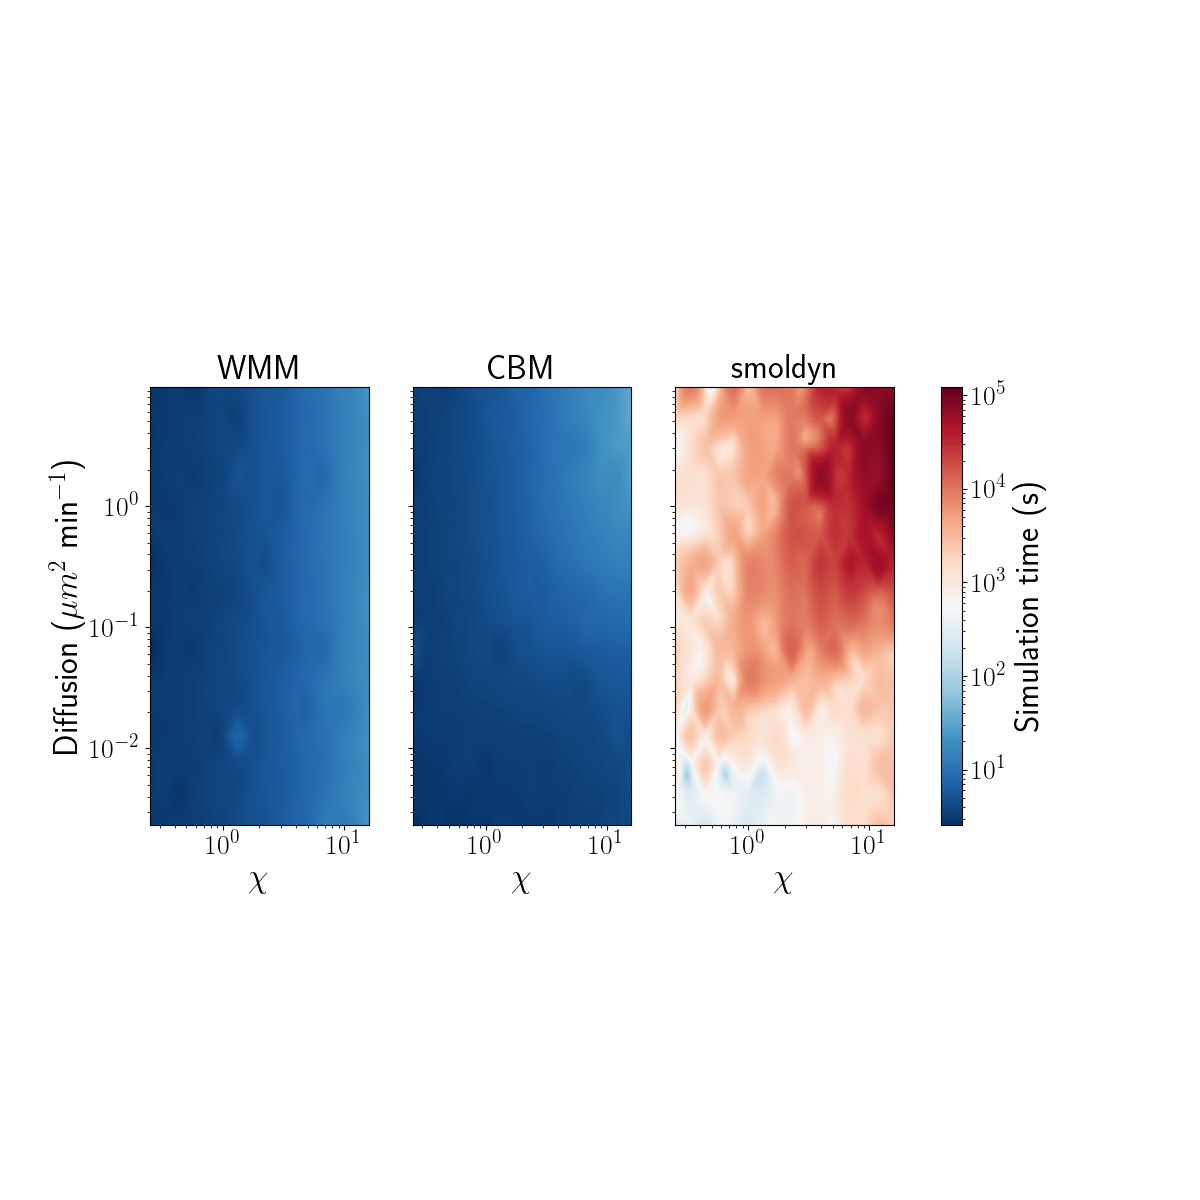

In [7]:
params = {'legend.fontsize': 20,
          #'figure.figsize': (6, 6),
         'figure.figsize': (12, 12),
         'figure.titlesize': 28,
         'axes.labelsize': 24,
         'axes.titlesize':24,
         'xtick.labelsize':20,
         'ytick.labelsize':20,
         'text.usetex':True,
         'figure.autolayout':False,
         }

plt.rcParams.update(params)

import scipy.interpolate as sci
import matplotlib.colors as colors

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
#fig.tight_layout(w_pad=0)

for i, solver in enumerate(['WMM', 'CBM', 'smoldyn']):
    time = data[solver]

    min_x = log_value(min(time.keys(), key=lambda t: t[1])[1])
    max_x = log_value(max(time.keys(), key=lambda t: t[1])[1])

    min_D = log_value(min(time.keys(), key=lambda t: t[0])[0], 'diffusion')
    max_D = log_value(max(time.keys(), key=lambda t: t[0])[0], 'diffusion')

    raw_grid = np.array([[log_value(chi), log_value(D, 'diffusion'), z[1]]
                         for ((D, chi, k_d), z) in time.items()
                        if k_d == 0])


    XY = raw_grid[:, :2]
    Z = raw_grid[:, 2]

    xi, yi = np.mgrid[min_x:max_x:100j, min_D:max_D:100j]
    grid_z2 = sci.griddata(XY, Z, (xi, yi) , method='cubic')

    pcm = ax[i].imshow(grid_z2.T, extent=(min_x, max_x, min_D, max_D),
               norm=colors.LogNorm(),
               origin='lower', vmin=min_time, vmax=max_time, cmap='RdBu_r')

    if not i:
        ax[i].set_ylabel('Diffusion ($\mu m^2$ min$^{-1}$)')

    ax[i].set_xlabel('$\chi$')
    
    ax[i].set_title(f"{solver}")

    xticks = list(range(int(np.ceil(min_x)), int(np.floor(max_x))+1))
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels([f'$10^{{{t}}}$' for t in xticks])
    ax[i].xaxis.set_minor_locator(mpt.FixedLocator(sum([[np.log10(i*c) for i in range(2,10)] for c in [0.001, 0.01, 0.1, 1, 10]],[])))

    yticks = list(range(int(np.ceil(min_D)), int(np.floor(max_D))+1))
    ax[i].set_yticks(yticks)
    ax[i].set_yticklabels([f'$10^{{{t}}}$' for t in yticks])
    ax[i].yaxis.set_minor_locator(mpt.FixedLocator(sum([[np.log10(i*c) for i in range(2,10)] for c in [0.001, 0.01, 0.1, 1, 10]],[])))

cb = fig.colorbar(pcm, ax=ax[:], location='right', shrink=0.475)
cb.set_label('Simulation time (s)')

plt.savefig('timeSolver.pdf', bbox_inches='tight')